## Docker specific configurations

Prepare python path

In [1]:
from sys import path
from pathlib import Path
path.append(str(Path("../../").resolve()))

## Prepare mesh

Generate mesh outside of the docker using the following commands:
```bash
gmsh collimator.geo -setnumber geomtype 0 -2 -o collimator_sibc.msh
../../tools/convert_msh.py collimator_sibc.msh collimator_sibc.xdmf
gmsh collimator.geo -setnumber geomtype 1 -2 -o collimator_metal.msh
../../tools/convert_msh.py collimator_metal.msh collimator_metal.xdmf
```

## Solution preparation

Import BeamImpedance2D module

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam
import numpy as np

In [3]:
beam.index = 1
vacuum.index = 2
carbon = bi2d.Material(3, sigma=1e4)
wall = carbon.copy()
wall.index = -1

Setup mesh and materials

In [4]:
m_sibc = bi2d.Mesh("collimator_sibc.xdmf")
mc_sibc = bi2d.MaterialMap(m_sibc, [beam, vacuum])
m_metal = bi2d.Mesh("collimator_metal.xdmf")
mc_metal = bi2d.MaterialMap(m_metal, [beam, vacuum, carbon])

Configure solution

In [16]:
solution_sibc = bi2d.Solution(mc_sibc, Hcurl_order=1, H1_order=1)
solution_sibc.logger.setLevel(logging.INFO)
solution_metal = bi2d.Solution(mc_metal, Hcurl_order=1, H1_order=1)
solution_metal.logger.setLevel(logging.INFO)

## Calculate impedance

Calculate impedance in frequency range and save the results

In [6]:
%%time

data_sibc_monopole_01 = solution_sibc.get_z(np.logspace(6, 11, num=30), beta=0.1, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[wall])
data_sibc_monopole_09 = solution_sibc.get_z(np.logspace(6, 11, num=30), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[wall])

INFO:bi2d.solution:Solving for f=1.00e+06, β=0.10
INFO:bi2d.solution:Solving for f=1.49e+06, β=0.10
INFO:bi2d.solution:Solving for f=2.21e+06, β=0.10
INFO:bi2d.solution:Solving for f=3.29e+06, β=0.10
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.10
INFO:bi2d.solution:Solving for f=7.28e+06, β=0.10
INFO:bi2d.solution:Solving for f=1.08e+07, β=0.10
INFO:bi2d.solution:Solving for f=1.61e+07, β=0.10
INFO:bi2d.solution:Solving for f=2.40e+07, β=0.10
INFO:bi2d.solution:Solving for f=3.56e+07, β=0.10
INFO:bi2d.solution:Solving for f=5.30e+07, β=0.10
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.10
INFO:bi2d.solution:Solving for f=1.17e+08, β=0.10
INFO:bi2d.solution:Solving for f=1.74e+08, β=0.10
INFO:bi2d.solution:Solving for f=2.59e+08, β=0.10
INFO:bi2d.solution:Solving for f=3.86e+08, β=0.10
INFO:bi2d.solution:Solving for f=5.74e+08, β=0.10
INFO:bi2d.solution:Solving for f=8.53e+08, β=0.10
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.10
INFO:bi2d.solution:Solving for f=1.89e+09, β=0.10


CPU times: user 30.5 s, sys: 1.22 s, total: 31.7 s
Wall time: 32.4 s


In [18]:
%%time

data_metal_monopole_01 = solution_metal.get_z(np.logspace(2, 7, num=30), beta=0.1, source_function=bi2d.SourceFunction.MONOPOLE)
data_metal_monopole_09 = solution_metal.get_z(np.logspace(2, 7, num=30), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE)

INFO:bi2d.solution:Solving for f=1.00e+02, β=0.10
INFO:bi2d.solution:Solving for f=1.49e+02, β=0.10
INFO:bi2d.solution:Solving for f=2.21e+02, β=0.10
INFO:bi2d.solution:Solving for f=3.29e+02, β=0.10
INFO:bi2d.solution:Solving for f=4.89e+02, β=0.10
INFO:bi2d.solution:Solving for f=7.28e+02, β=0.10
INFO:bi2d.solution:Solving for f=1.08e+03, β=0.10
INFO:bi2d.solution:Solving for f=1.61e+03, β=0.10
INFO:bi2d.solution:Solving for f=2.40e+03, β=0.10
INFO:bi2d.solution:Solving for f=3.56e+03, β=0.10
INFO:bi2d.solution:Solving for f=5.30e+03, β=0.10
INFO:bi2d.solution:Solving for f=7.88e+03, β=0.10
INFO:bi2d.solution:Solving for f=1.17e+04, β=0.10
INFO:bi2d.solution:Solving for f=1.74e+04, β=0.10
INFO:bi2d.solution:Solving for f=2.59e+04, β=0.10
INFO:bi2d.solution:Solving for f=3.86e+04, β=0.10
INFO:bi2d.solution:Solving for f=5.74e+04, β=0.10
INFO:bi2d.solution:Solving for f=8.53e+04, β=0.10
INFO:bi2d.solution:Solving for f=1.27e+05, β=0.10
INFO:bi2d.solution:Solving for f=1.89e+05, β=0.10


CPU times: user 1min 15s, sys: 3.48 s, total: 1min 19s
Wall time: 1min 18s


## Plot impedances

In [19]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

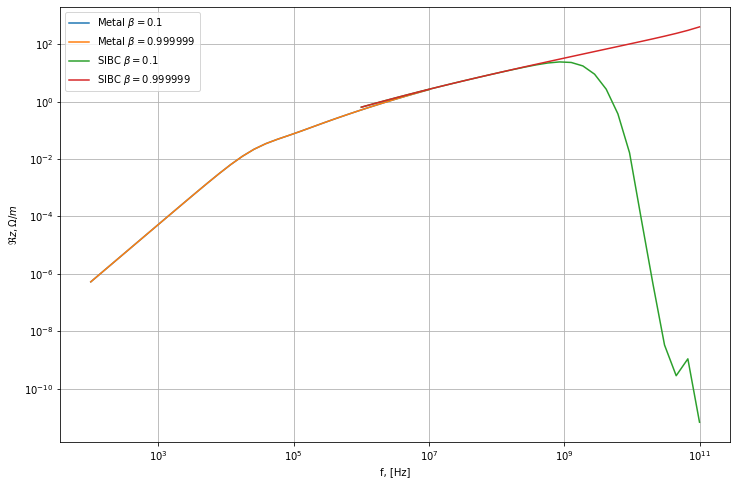

In [35]:
pylab.plot(data_metal_monopole_01[:,0], data_metal_monopole_01[:,1])
pylab.plot(data_metal_monopole_09[:,0], data_metal_monopole_09[:,1])
pylab.plot(data_sibc_monopole_01[:,0], data_sibc_monopole_01[:,1])
pylab.plot(data_sibc_monopole_09[:,0], data_sibc_monopole_09[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\Re{z}, \Omega/m$")
pylab.grid()
pylab.legend([r"Metal $\beta=0.1$", r"Metal $\beta=0.999999$", r"SIBC $\beta=0.1$", r"SIBC $\beta=0.999999$"])
pylab.show()

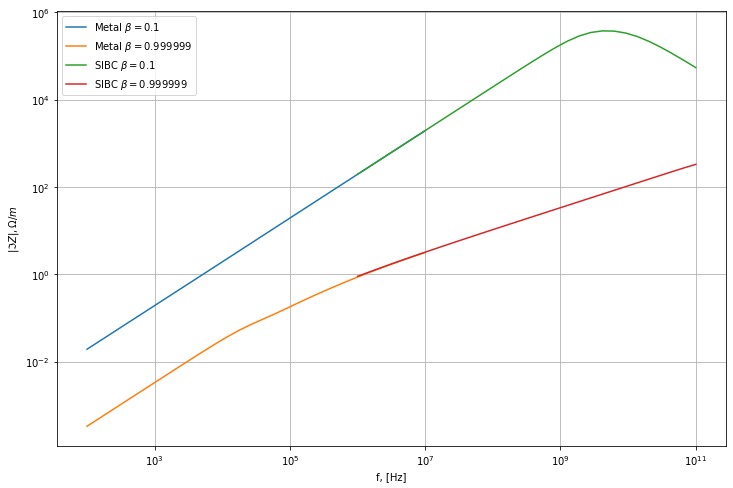

In [34]:
pylab.plot(data_metal_monopole_01[:,0], np.abs(data_metal_monopole_01[:,2]))
pylab.plot(data_metal_monopole_09[:,0], np.abs(data_metal_monopole_09[:,2]))
pylab.plot(data_sibc_monopole_01[:,0], np.abs(data_sibc_monopole_01[:,2]))
pylab.plot(data_sibc_monopole_09[:,0], np.abs(data_sibc_monopole_09[:,2]))
pylab.xscale("log")
pylab.yscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Im{z}|, \Omega/m$")
pylab.grid()
pylab.legend([r"Metal $\beta=0.1$", r"Metal $\beta=0.999999$", r"SIBC $\beta=0.1$", r"SIBC $\beta=0.999999$"])
pylab.show()

In [10]:
%%time

data_sibc_dipole_0_01 = solution_sibc.get_z(np.logspace(6, 11, num=30), beta=0.1, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])
data_sibc_dipole_0_09 = solution_sibc.get_z(np.logspace(6, 11, num=30), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

INFO:bi2d.solution:Solving for f=1.00e+06, β=0.10
INFO:bi2d.solution:Solving for f=1.49e+06, β=0.10
INFO:bi2d.solution:Solving for f=2.21e+06, β=0.10
INFO:bi2d.solution:Solving for f=3.29e+06, β=0.10
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.10
INFO:bi2d.solution:Solving for f=7.28e+06, β=0.10
INFO:bi2d.solution:Solving for f=1.08e+07, β=0.10
INFO:bi2d.solution:Solving for f=1.61e+07, β=0.10
INFO:bi2d.solution:Solving for f=2.40e+07, β=0.10
INFO:bi2d.solution:Solving for f=3.56e+07, β=0.10
INFO:bi2d.solution:Solving for f=5.30e+07, β=0.10
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.10
INFO:bi2d.solution:Solving for f=1.17e+08, β=0.10
INFO:bi2d.solution:Solving for f=1.74e+08, β=0.10
INFO:bi2d.solution:Solving for f=2.59e+08, β=0.10
INFO:bi2d.solution:Solving for f=3.86e+08, β=0.10
INFO:bi2d.solution:Solving for f=5.74e+08, β=0.10
INFO:bi2d.solution:Solving for f=8.53e+08, β=0.10
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.10
INFO:bi2d.solution:Solving for f=1.89e+09, β=0.10


CPU times: user 30.3 s, sys: 1.33 s, total: 31.6 s
Wall time: 31.8 s


In [36]:
%%time

data_metal_dipole_0_01 = solution_metal.get_z(np.logspace(2, 7, num=30), beta=0.1, source_function=bi2d.SourceFunction.DIPOLE)
data_metal_dipole_0_09 = solution_metal.get_z(np.logspace(2, 7, num=30), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE)

INFO:bi2d.solution:Solving for f=1.00e+02, β=0.10
INFO:bi2d.solution:Solving for f=1.49e+02, β=0.10
INFO:bi2d.solution:Solving for f=2.21e+02, β=0.10
INFO:bi2d.solution:Solving for f=3.29e+02, β=0.10
INFO:bi2d.solution:Solving for f=4.89e+02, β=0.10
INFO:bi2d.solution:Solving for f=7.28e+02, β=0.10
INFO:bi2d.solution:Solving for f=1.08e+03, β=0.10
INFO:bi2d.solution:Solving for f=1.61e+03, β=0.10
INFO:bi2d.solution:Solving for f=2.40e+03, β=0.10
INFO:bi2d.solution:Solving for f=3.56e+03, β=0.10
INFO:bi2d.solution:Solving for f=5.30e+03, β=0.10
INFO:bi2d.solution:Solving for f=7.88e+03, β=0.10
INFO:bi2d.solution:Solving for f=1.17e+04, β=0.10
INFO:bi2d.solution:Solving for f=1.74e+04, β=0.10
INFO:bi2d.solution:Solving for f=2.59e+04, β=0.10
INFO:bi2d.solution:Solving for f=3.86e+04, β=0.10
INFO:bi2d.solution:Solving for f=5.74e+04, β=0.10
INFO:bi2d.solution:Solving for f=8.53e+04, β=0.10
INFO:bi2d.solution:Solving for f=1.27e+05, β=0.10
INFO:bi2d.solution:Solving for f=1.89e+05, β=0.10


CPU times: user 1min 15s, sys: 2.6 s, total: 1min 17s
Wall time: 1min 17s


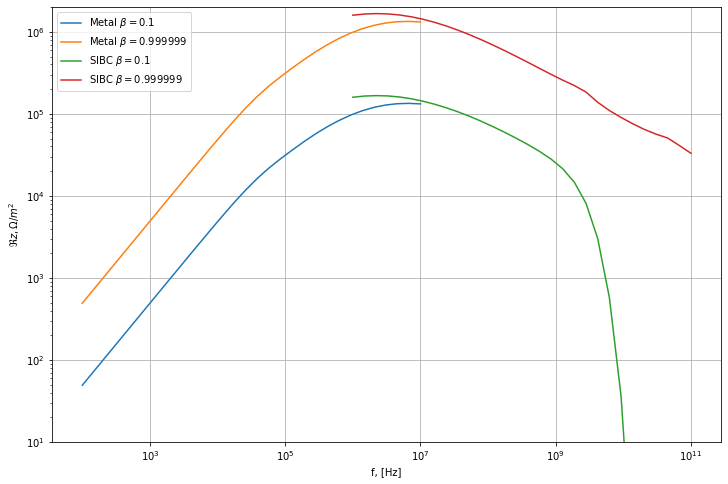

In [57]:
pylab.plot(data_metal_dipole_0_01[:,0], data_metal_dipole_0_01[:,1])
pylab.plot(data_metal_dipole_0_09[:,0], data_metal_dipole_0_09[:,1])
pylab.plot(data_sibc_dipole_0_01[:,0], data_sibc_dipole_0_01[:,1])
pylab.plot(data_sibc_dipole_0_09[:,0], data_sibc_dipole_0_09[:,1])
pylab.yscale("log")
pylab.ylim((1e1, 2e6))
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\Re{z}, \Omega/m^2$")
pylab.grid()
pylab.legend([r"Metal $\beta=0.1$", r"Metal $\beta=0.999999$", r"SIBC $\beta=0.1$", r"SIBC $\beta=0.999999$"])
pylab.show()

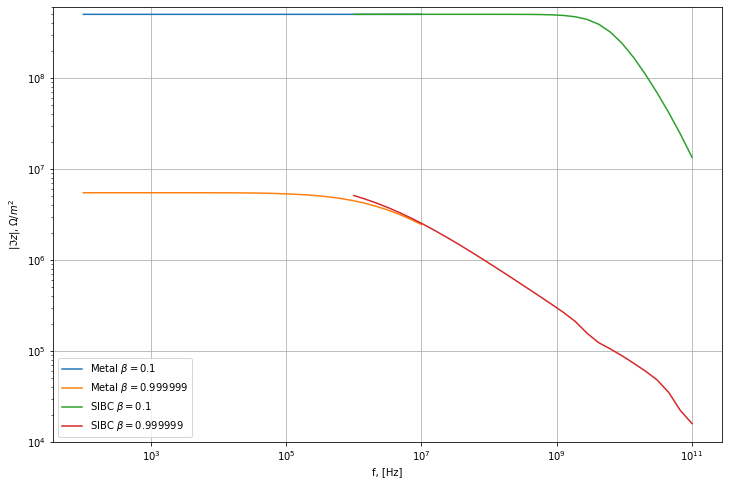

In [51]:
pylab.plot(data_metal_dipole_0_01[:,0], np.abs(data_metal_dipole_0_01[:,2]))
pylab.plot(data_metal_dipole_0_09[:,0], np.abs(data_metal_dipole_0_09[:,2]))
pylab.plot(data_sibc_dipole_0_01[:,0], np.abs(data_sibc_dipole_0_01[:,2]))
pylab.plot(data_sibc_dipole_0_09[:,0], np.abs(data_sibc_dipole_0_09[:,2]))
pylab.yscale("log")
pylab.ylim((1e4, 6e8))
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Im{z}|, \Omega/m^2$")
pylab.grid()
pylab.legend([r"Metal $\beta=0.1$", r"Metal $\beta=0.999999$", r"SIBC $\beta=0.1$", r"SIBC $\beta=0.999999$"])
pylab.show()

In [13]:
%%time

data_sibc_dipole_90_01 = solution_sibc.get_z(np.logspace(6, 11, num=30), beta=0.1, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])
data_sibc_dipole_90_09 = solution_sibc.get_z(np.logspace(6, 11, num=30), beta=0.999999, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

INFO:bi2d.solution:Solving for f=1.00e+06, β=0.10
INFO:bi2d.solution:Solving for f=1.49e+06, β=0.10
INFO:bi2d.solution:Solving for f=2.21e+06, β=0.10
INFO:bi2d.solution:Solving for f=3.29e+06, β=0.10
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.10
INFO:bi2d.solution:Solving for f=7.28e+06, β=0.10
INFO:bi2d.solution:Solving for f=1.08e+07, β=0.10
INFO:bi2d.solution:Solving for f=1.61e+07, β=0.10
INFO:bi2d.solution:Solving for f=2.40e+07, β=0.10
INFO:bi2d.solution:Solving for f=3.56e+07, β=0.10
INFO:bi2d.solution:Solving for f=5.30e+07, β=0.10
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.10
INFO:bi2d.solution:Solving for f=1.17e+08, β=0.10
INFO:bi2d.solution:Solving for f=1.74e+08, β=0.10
INFO:bi2d.solution:Solving for f=2.59e+08, β=0.10
INFO:bi2d.solution:Solving for f=3.86e+08, β=0.10
INFO:bi2d.solution:Solving for f=5.74e+08, β=0.10
INFO:bi2d.solution:Solving for f=8.53e+08, β=0.10
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.10
INFO:bi2d.solution:Solving for f=1.89e+09, β=0.10


CPU times: user 30 s, sys: 1.1 s, total: 31.1 s
Wall time: 31.2 s


In [52]:
%%time

data_metal_dipole_90_01 = solution_metal.get_z(np.logspace(2, 7, num=30), beta=0.1, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE)
data_metal_dipole_90_09 = solution_metal.get_z(np.logspace(2, 7, num=30), beta=0.999999, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE)

INFO:bi2d.solution:Solving for f=1.00e+02, β=0.10
INFO:bi2d.solution:Solving for f=1.49e+02, β=0.10
INFO:bi2d.solution:Solving for f=2.21e+02, β=0.10
INFO:bi2d.solution:Solving for f=3.29e+02, β=0.10
INFO:bi2d.solution:Solving for f=4.89e+02, β=0.10
INFO:bi2d.solution:Solving for f=7.28e+02, β=0.10
INFO:bi2d.solution:Solving for f=1.08e+03, β=0.10
INFO:bi2d.solution:Solving for f=1.61e+03, β=0.10
INFO:bi2d.solution:Solving for f=2.40e+03, β=0.10
INFO:bi2d.solution:Solving for f=3.56e+03, β=0.10
INFO:bi2d.solution:Solving for f=5.30e+03, β=0.10
INFO:bi2d.solution:Solving for f=7.88e+03, β=0.10
INFO:bi2d.solution:Solving for f=1.17e+04, β=0.10
INFO:bi2d.solution:Solving for f=1.74e+04, β=0.10
INFO:bi2d.solution:Solving for f=2.59e+04, β=0.10
INFO:bi2d.solution:Solving for f=3.86e+04, β=0.10
INFO:bi2d.solution:Solving for f=5.74e+04, β=0.10
INFO:bi2d.solution:Solving for f=8.53e+04, β=0.10
INFO:bi2d.solution:Solving for f=1.27e+05, β=0.10
INFO:bi2d.solution:Solving for f=1.89e+05, β=0.10


CPU times: user 1min 15s, sys: 2.69 s, total: 1min 18s
Wall time: 1min 18s


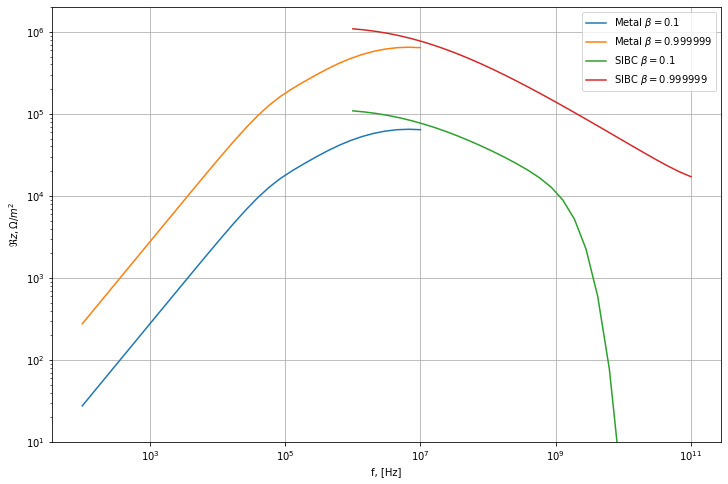

In [55]:
pylab.plot(data_metal_dipole_90_01[:,0], data_metal_dipole_90_01[:,1])
pylab.plot(data_metal_dipole_90_09[:,0], data_metal_dipole_90_09[:,1])
pylab.plot(data_sibc_dipole_90_01[:,0], data_sibc_dipole_90_01[:,1])
pylab.plot(data_sibc_dipole_90_09[:,0], data_sibc_dipole_90_09[:,1])
pylab.yscale("log")
pylab.ylim((1e1, 2e6))
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\Re{z}, \Omega/m^2$")
pylab.grid()
pylab.legend([r"Metal $\beta=0.1$", r"Metal $\beta=0.999999$", r"SIBC $\beta=0.1$", r"SIBC $\beta=0.999999$"])
pylab.show()

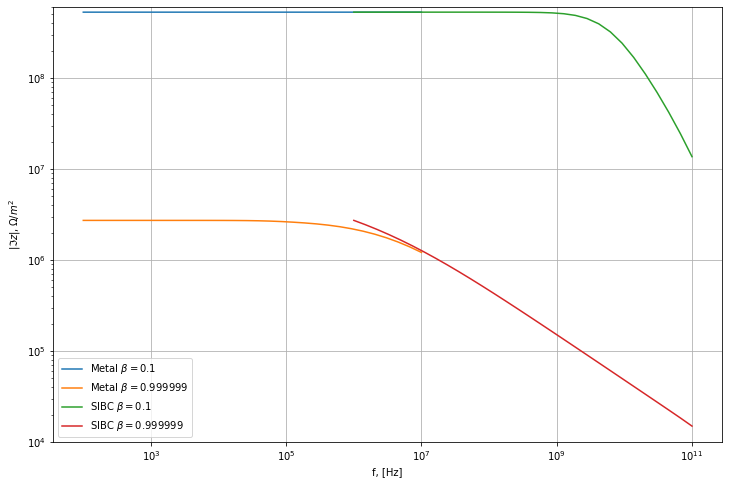

In [56]:
pylab.plot(data_metal_dipole_90_01[:,0], np.abs(data_metal_dipole_90_01[:,2]))
pylab.plot(data_metal_dipole_90_09[:,0], np.abs(data_metal_dipole_90_09[:,2]))
pylab.plot(data_sibc_dipole_90_01[:,0], np.abs(data_sibc_dipole_90_01[:,2]))
pylab.plot(data_sibc_dipole_90_09[:,0], np.abs(data_sibc_dipole_90_09[:,2]))
pylab.yscale("log")
pylab.ylim((1e4, 6e8))
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Im{z}|, \Omega/m^2$")
pylab.grid()
pylab.legend([r"Metal $\beta=0.1$", r"Metal $\beta=0.999999$", r"SIBC $\beta=0.1$", r"SIBC $\beta=0.999999$"])
pylab.show()